# CICERO SCM notebook - parallel application

Import some stuff

In [1]:
import sys
import re
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import pandas.testing as pdt
import warnings
import logging

try:
    from pandas.core.common import SettingWithCopyWarning
except:
    from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.filterwarnings("ignore", message=".*Parameter.*")

In [2]:
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

In [3]:
import concurrent

In [4]:
from ciceroscm.parallel._configdistro import _ConfigDistro
from ciceroscm.parallel.calibrator import Calibrator
from ciceroscm.parallel.distributionrun import DistributionRun


/uio/kant/div-cicero-u1/bensan/ciceroscm-1/venv/lib/python3.8/site-packages/scmdata/database/_database.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman
/uio/kant/div-cicero-u1/bensan/ciceroscm-1/venv/lib/python3.8/site-packages/setuptools_scm/_integration/setuptools.py:31: RuntimeWarning: 
ERROR: setuptools==47.1.0 is used in combination with setuptools_scm>=8.x

Your build configuration is incomplete and previously worked by accident!
setuptools_scm requires setuptools>=61

Suggested workaround if applicable:
 - migrating from the deprecated setup_requires mechanism to pep517/518
   and using a pyproject.toml to declare build dependencies
   which are reliably pre-installed before running the build tools

  warnings.warn(


<IPython.core.display.Javascript object>

Import the model

In [5]:
sys.path.insert(0,os.path.join(os.getcwd(), '../', 'src'))
from ciceroscm import CICEROSCM

Define some input handling functions to give us example inputs

In [6]:
from ciceroscm.input_handler import read_inputfile,read_components,read_natural_emissions

Define a function to convert model output to a dataframe

set up input directories

In [7]:
test_data_dir = os.path.join(os.getcwd(), '../', 'tests', 'test-data')

# Read in datafiles into dataframes

In [8]:
# NBVAL_IGNORE_OUTPUT
#Read gas parameters
gaspam =read_components(test_data_dir + '/gases_v1RCMIP.txt')
gaspam.head()

,EM_UNIT,CONC_UNIT,BETA,ALPHA,TAU1,TAU2,TAU3,NAT_EM,SARF_TO_ERF
GAS,,,,,,,,,
CO2,Pg_C,ppm,2.123,0.00000,150.00,0,0,0.0,1.000000
CH4,Tg,ppb,2.780,0.00000,9.60,120,160,275.0,0.877193
N2O,Tg_N,ppb,4.810,0.00000,121.00,0,0,9.5,1.000000
SO2,Tg_S,-,11.000,0.00000,0.02,0,0,0.0,1.000000
CFC-11,Gg,ppt,22.600,0.00026,45.00,0,0,0.0,1.000000


Read natural emissions

In [9]:
# NBVAL_IGNORE_OUTPUT
df_nat_ch4 =read_natural_emissions(test_data_dir + '/natemis_ch4.txt','CH4')
df_nat_n2o =read_natural_emissions(test_data_dir + '/natemis_n2o.txt','N2O')
df_nat_ch4.head()


,CH4
year,
1750,269.4273
1751,270.9068
1752,273.0183
1753,272.0470
1754,271.1915


Read forcing

In [10]:
df_ssp2_conc =read_inputfile(test_data_dir + '/ssp245_conc_RCMIP.txt')
df_ssp2_conc.head()

,CO2,CH4,N2O,CFC-11,CFC-12,CFC-113,CFC-114,CFC-115,CH3Br,CCl4,...,HFC143a,HFC227ea,HFC23,HFC245fa,HFC32,HFC4310mee,C2F6,C6F14,CF4,SF6
Component,,,,,,,,,,,,,,,,,,,,,
1700,276.746000,706.054021,272.212049,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1701,276.749995,706.247004,272.243047,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1702,276.757998,706.375031,272.266047,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1703,276.757001,706.491002,272.298047,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1704,276.755000,706.602046,272.331052,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0


In [11]:
emi_input =read_inputfile(test_data_dir + '/ssp245_em_RCMIP.txt')
emi_input.rename(columns={"CO2": "CO2_FF", "CO2.1": "CO2_AFOLU"}, inplace=True)
emi_input.head()

,CO2_FF,CO2_AFOLU,CH4,N2O,SO2,CFC-11,CFC-12,CFC-113,CFC-114,CFC-115,...,CF4,SF6,NOx,CO,NMVOC,NH3,BMB_AEROS_BC,BMB_AEROS_OC,BC,OC
Component,,,,,,,,,,,,,,,,,,,,,
1750,0.002592,0.081127,19.019783,0.054710,1.222464,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.871504,348.527359,60.021826,6.927690,1.353250,12.520269,0.744520,2.927399
1751,0.002593,0.082619,18.915109,0.055744,1.206598,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.828060,343.926367,59.088126,6.860142,1.335274,12.279280,0.737652,2.909437
1752,0.002594,0.084139,18.889712,0.056797,1.200955,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.828658,341.809034,58.631997,6.819482,1.326617,12.121816,0.737695,2.912659
1753,0.002594,0.085687,19.121377,0.057870,1.207757,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.812105,343.675456,59.026349,6.881439,1.328560,12.249330,0.743391,2.933215
1754,0.002595,0.087263,19.509061,0.058963,1.233495,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.841598,349.815625,60.269945,7.015189,1.346553,12.593635,0.752796,2.965138


# Set up model run with defined input variables

In [12]:
scendata={
            "gaspam_data": gaspam,
            "emstart": 1750,  
            "conc_run":False,
            "nystart": 1750,
            "nyend": 2100,
            "concentrations_data": df_ssp2_conc,
            "emissions_data": emi_input,
            "nat_ch4_data": df_nat_ch4,
            "nat_n2o_data": df_nat_n2o,
            "idtm":24,
            "udir": test_data_dir,
            "scenname": "ssp245",
        }

In [13]:
    calibdata = pd.DataFrame(
        data={
            "Variable Name": [
                "Heat Content|Ocean",
                "Surface Air Ocean Blended Temperature Change",
            ],
            "Yearstart_norm": [1971, 1961],
            "Yearend_norm": [1971, 1990],
            "Yearstart_change": [2018, 2000],
            "Yearend_change": [2018, 2019],
            "Central Value": [320.69251537323, 0.5372],
            "sigma": [17.020342912051203, 0.039028311931729676],
        })

In [14]:
    testconfig = _ConfigDistro(
        distro_array=np.array([[0, 1], [0, 1], [0, 1], [4, 6]]),
        setvalues={
            "qbmb": 0,
            "qo3": 0.5,
            "threstemp": 7.0,
            "lm": 40,
            "ldtime": 12,
        },
    )

In [15]:
testconfig.ordering

['rlamdo',
 'akapa',
 'cpi',
 'W',
 'beto',
 'lambda',
 'mixed',
 'qdirso2',
 'qindso2',
 'qbc',
 'qoc',
 'beta_f',
 'mixed_carbon',
 'qh2o_ch4']

In [16]:
# NBVAL_IGNORE_OUTPUT
scen = 'test'
cscm_dir=CICEROSCM({
            "gaspam_data": gaspam,
            "emstart": 1750,  
            "conc_run":False,
            "nystart": 1750,
            "nyend": 2100,
            "concentrations_data": df_ssp2_conc,
            "emissions_data": emi_input,
            "nat_ch4_data": df_nat_ch4,
            "nat_n2o_data": df_nat_n2o,
            "idtm":24,
        })

In [20]:
distrorun1 = DistributionRun(testconfig, numvalues=50000)
output_vars = ["Heat Uptake", "Surface Air Temperature Change"]


[ 0.          0.          0.          4.          0.          0.53908356
 25.         -0.55       -1.5         0.1        -0.1         0.11
 25.          0.08      ]
[ 1.00000000e+00  1.00000000e+00  1.00000000e+00  6.00000000e+00
  7.00000000e+00  1.34770889e+00  1.25000000e+02 -2.00000000e-01
 -5.00000000e-01  2.00000000e-01 -6.00000000e-02  4.65000000e-01
  1.25000000e+02  1.00000000e-01]


In [21]:
def get_results(cfg):
    try:
        cscm_dir._run({"results_as_dict": True},pamset_udm=cfg['pamset_udm'],pamset_emiconc=cfg['pamset_emiconc'])
        res=cscm_dir.results

    except:
        res=None
    return [cfg,res]

In [22]:
def run_parallel(cfgs,nworkers=4):
    results=len(cfgs)*[None]
    with ProcessPoolExecutor(nworkers) as exe:
            # execute tasks concurrently and process results in order
            pres=list(tqdm(exe.map(get_results, cfgs)))
            for result in pres:
                # get the corresponding index of the config
                ind=int(result[0]['Index'])
                # put it in the right element of the results vector
                results[ind]=result[1]
    return results

In [23]:
results=run_parallel(distrorun1.cfgs,nworkers=200)

In [21]:
flds=['dT_glob','OHCTOT','concentrations-CO2','RIB_glob']

In [22]:
distrorun1.cfgs[results!=None]

{'pamset_udm': {'threstemp': 7.0,
  'lm': 40,
  'ldtime': 12,
  'rlamdo': 0.08701581746123738,
  'akapa': 0.7483565932069641,
  'cpi': 0.893303919352098,
  'W': 5.13795120463851,
  'beto': 2.092649975291529,
  'lambda': 0.8446767806809223,
  'mixed': 121.56939806543645},
 'pamset_emiconc': {'qbmb': 0,
  'qo3': 0.5,
  'qdirso2': -0.39974325726229576,
  'qindso2': -1.1713743538366341,
  'qbc': 0.12761650360496837,
  'qoc': -0.08736895030366261,
  'beta_f': 0.24200080446006544,
  'mixed_carbon': 98.21662838763527,
  'qh2o_ch4': 0.08733733289113109},
 'Index': '1'}

In [23]:
isgd=np.where([r!=None for r in results])[0].astype(int)

In [ ]:
fresults = [results[i] for i in isgd]
fcfgs=[distrorun1.cfgs[i] for i in isgd]

In [26]:
def to_df(rs):

    out=pd.concat([pd.DataFrame(v).reset_index(drop=True) for k, v in rs.items()], keys = rs.keys(),axis=1) 
    out.index=rs['forcing'].index
    return out

In [27]:
def make_ensdf(results,flds):
    resdf=[]
    for i,res in enumerate(results):
        df=to_df(res)
        test_list=df.columns.map('{0[0]}-{0[1]}'.format).tolist()
        df.columns=[sub.replace('-0', '') for sub in test_list]
        resdf.append(df[flds].unstack())
    ensdf=pd.concat(resdf,axis=1)
    return ensdf

In [ ]:
df=make_ensdf(fresults,flds)

In [51]:
issane=np.where(df.max()<1e8)[0]

In [54]:
fresults = [fresults[i] for i in issane]
fcfgs=[fcfgs[i] for i in issane]

In [56]:
df=make_ensdf(fresults,flds)

In [29]:
df.index.names = ['variable', 'year']
df.columns.names=['run_id']

In [57]:
def plot_range(df, var, ax,col='k'):
    Tdf=df.xs(var).T
    lower = Tdf.quantile(0.10)
    upper = Tdf.quantile(0.90)
    ax.fill_between(Tdf.columns, lower, upper, color=col, alpha=0.2,edgecolor=None)
    ax.plot(Tdf.columns, Tdf.mean(), color=col)



(0.0, 5.0)

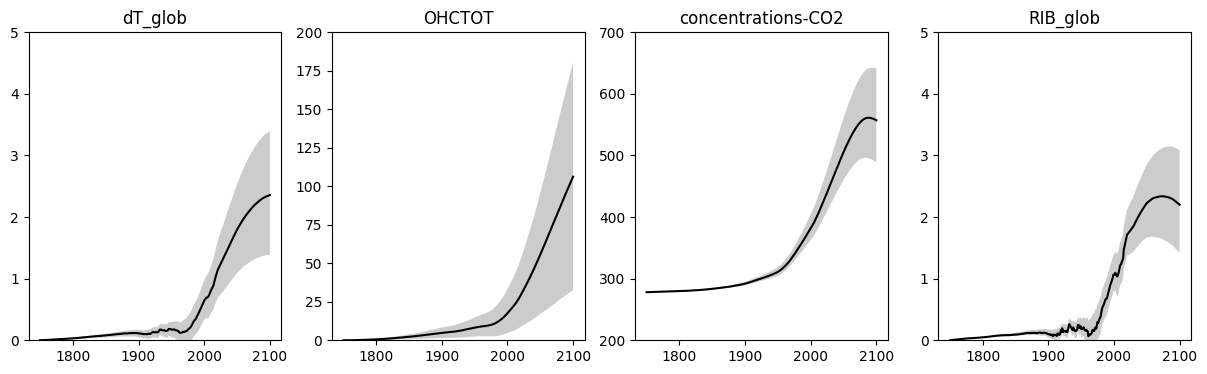

In [58]:
fig, ax = plt.subplots( 1,len(flds) ,figsize=(15, 4))

ax=ax.flatten()
for i,f in enumerate(flds):
    plot_range(df, f, ax[i])
    ax[i].set_title(f)
ax[0].set_ylim([0,5])
ax[1].set_ylim([0,200])
ax[2].set_ylim([200,700])
ax[3].set_ylim([0,5])



In [59]:
dates=[1950,1970,1990,2005,2018]
targ=df.loc[(slice(None), dates), :].T
nflds=targ.shape[1]


In [60]:
def merge_dicts(dc):
    """Given two dictionaries, merge them into a new dict as a shallow copy."""
    x=dc['pamset_udm']
    y=dc['pamset_emiconc']
    z = x.copy()
    z.update(y)
    return z

In [61]:
pdict=fcfgs
mdict=[ merge_dicts(d) for d in pdict ]
pmat=pd.DataFrame(mdict)

In [63]:
pmat

,threstemp,lm,ldtime,rlamdo,akapa,cpi,W,beto,lambda,mixed,qbmb,qo3,qdirso2,qindso2,qbc,qoc,beta_f,mixed_carbon,qh2o_ch4
0,7.0,40,12,0.087016,0.748357,0.893304,5.137951,2.092650,0.844677,121.569398,0,0.5,-0.399743,-1.171374,0.127617,-0.087369,0.242001,98.216628,0.087337
1,7.0,40,12,0.120054,0.901880,0.983932,5.347852,3.033703,0.998796,70.597976,0,0.5,-0.504652,-1.351302,0.119281,-0.061311,0.132435,111.100069,0.087122
2,7.0,40,12,0.864981,0.501865,0.474639,4.730954,5.476207,0.616765,96.899452,0,0.5,-0.229976,-1.009204,0.124279,-0.086764,0.463461,93.483283,0.084499
3,7.0,40,12,0.357933,0.746289,0.307882,4.582284,5.773733,1.213214,45.996933,0,0.5,-0.333683,-0.598509,0.146985,-0.089546,0.205500,70.804485,0.094887
4,7.0,40,12,0.929494,0.756245,0.998582,4.095747,1.094050,1.080497,121.415715,0,0.5,-0.214224,-0.776145,0.144050,-0.068066,0.416784,41.845501,0.098406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9991,7.0,40,12,0.335483,0.927528,0.378072,5.704477,4.382512,1.336375,45.407249,0,0.5,-0.510596,-0.730729,0.161653,-0.077252,0.146796,55.715880,0.092381
9992,7.0,40,12,0.574669,0.339390,0.348254,5.723032,0.484633,0.562376,117.320454,0,0.5,-0.426000,-0.601501,0.109253,-0.064861,0.297379,63.938140,0.086590
9993,7.0,40,12,0.352197,0.842391,0.817737,4.216900,4.557194,1.320526,109.930940,0,0.5,-0.477389,-0.614507,0.118600,-0.067568,0.406993,29.863635,0.094752
9994,7.0,40,12,0.130166,0.281285,0.268932,4.064894,4.526415,1.267701,71.914128,0,0.5,-0.390521,-1.188654,0.122341,-0.067324,0.464298,89.517061,0.098923


In [64]:
parammat=pmat.loc[:, (pmat != pmat.iloc[0]).any()]
parammat

,rlamdo,akapa,cpi,W,beto,lambda,mixed,qdirso2,qindso2,qbc,qoc,beta_f,mixed_carbon,qh2o_ch4
0,0.087016,0.748357,0.893304,5.137951,2.092650,0.844677,121.569398,-0.399743,-1.171374,0.127617,-0.087369,0.242001,98.216628,0.087337
1,0.120054,0.901880,0.983932,5.347852,3.033703,0.998796,70.597976,-0.504652,-1.351302,0.119281,-0.061311,0.132435,111.100069,0.087122
2,0.864981,0.501865,0.474639,4.730954,5.476207,0.616765,96.899452,-0.229976,-1.009204,0.124279,-0.086764,0.463461,93.483283,0.084499
3,0.357933,0.746289,0.307882,4.582284,5.773733,1.213214,45.996933,-0.333683,-0.598509,0.146985,-0.089546,0.205500,70.804485,0.094887
4,0.929494,0.756245,0.998582,4.095747,1.094050,1.080497,121.415715,-0.214224,-0.776145,0.144050,-0.068066,0.416784,41.845501,0.098406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9991,0.335483,0.927528,0.378072,5.704477,4.382512,1.336375,45.407249,-0.510596,-0.730729,0.161653,-0.077252,0.146796,55.715880,0.092381
9992,0.574669,0.339390,0.348254,5.723032,0.484633,0.562376,117.320454,-0.426000,-0.601501,0.109253,-0.064861,0.297379,63.938140,0.086590
9993,0.352197,0.842391,0.817737,4.216900,4.557194,1.320526,109.930940,-0.477389,-0.614507,0.118600,-0.067568,0.406993,29.863635,0.094752
9994,0.130166,0.281285,0.268932,4.064894,4.526415,1.267701,71.914128,-0.390521,-1.188654,0.122341,-0.067324,0.464298,89.517061,0.098923


In [65]:
targ

dT_glob                                             OHCTOT             \
          1950      1970      1990      2005      2018       1950       1970   
0     0.044159 -0.042041  0.140295  0.316942  0.574568   2.185163   2.400729   
1     0.013590 -0.140864  0.062248  0.285213  0.618245   2.908761   2.808183   
2     0.113594  0.090222  0.264692  0.458257  0.685911   7.894934   9.070714   
3     0.314152  0.382030  0.756811  1.085064  1.468469  13.078179  16.962304   
4     0.264969  0.311468  0.621361  0.920449  1.254853  21.158297  27.132488   
...        ...       ...       ...       ...       ...        ...        ...   
9991  0.285870  0.287511  0.669310  1.034968  1.483369  13.743666  17.173034   
9992  0.165816  0.189191  0.386032  0.578848  0.799359   7.910329   9.990236   
9993  0.265690  0.290526  0.643131  0.963727  1.352759  14.771277  18.819922   
9994  0.079535 -0.059961  0.206577  0.494900  0.903683   3.603829   3.726694   
9995  0.067581  0.031780  0.173456  0.317967  0.505136   4.898731   5.590202   

                                      concentrations-CO2              \
           1990       2005       2018               1950        1970   
0      3.101595   4.615930   6.504707         307.988220  327.337851   
1      3.255005   5.213572   7.852597         308.769902  328.532356   
2     13.081981  19.796800  27.397978         304.475750  321.955873   
3     24.607129  34.246335  44.799046         312.736413  334.523985   
4     39.351511  55.157165  72.510932         312.221441  333.818964   
...         ...        ...        ...                ...         ...   
9991  24.188504  34.098197  45.373052         317.567597  341.776835   
9992  14.629949  20.842429  27.616669         311.472686  332.632969   
9993  26.816465  37.475387  49.408382         314.938602  337.957354   
9994   4.758561   7.446015  10.831819         304.839037  322.513402   
9995   7.690466  11.415739  15.799182         304.115303  321.430727   

                                          RIB_glob                      \
            1990        2005        2018      1950      1970      1990   
0     356.754304  380.997710  408.986752  0.169975  0.053728  0.625998   
1     358.612561  383.399756  411.948291  0.088617 -0.129312  0.439919   
2     348.075826  369.293846  394.036358  0.137958  0.117436  0.609828   
3     368.400143  396.977982  429.646902  0.364634  0.492441  1.096994   
4     367.375654  395.637961  428.007690  0.347952  0.455483  1.077274   
...          ...         ...         ...       ...       ...       ...   
9991  379.982971  412.762834  449.927573  0.347829  0.392235  1.048996   
9992  365.407849  392.942915  424.507789  0.255503  0.329450  0.864359   
9993  373.997626  404.586033  439.443718  0.380587  0.469400  1.124660   
9994  348.993556  370.556520  395.675060  0.108460 -0.026451  0.516117   
9995  347.133797  367.846256  392.020420  0.161586  0.116387  0.638023   

                          
          2005      2018  
0     1.031356  1.724596  
1     0.864232  1.629201  
2     0.847318  1.335214  
3     1.442985  1.967939  
4     1.422553  1.973235  
...        ...       ...  
9991  1.466386  2.115388  
9992  1.133811  1.603391  
9993  1.533811  2.153272  
9994  0.875474  1.526789  
9995  0.943034  1.499805  

[9996 rows x 20 columns]

In [ ]:
store = pd.HDFStore('data.h5')
store['targ'] = targ
store['parammat'] = parammat


In [ ]:
store.close()

In [1]:
plt.plot(targ['dT_glob'][2018],pmat['lambda'],'.')

NameError: name 'plt' is not defined

In [67]:
from sklearn.model_selection import train_test_split
XTraining, XValidation, YTraining, YValidation = train_test_split(parammat,targ,test_size=0.1, shuffle=False) # before model building


In [68]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
print(tf.config.list_physical_devices())

2024-05-10 12:32:32.098984: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-10 12:32:32.214775: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-10 12:32:32.218088: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-10 12:32:35.212623: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.13.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [69]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(30, activation='tanh'),
      layers.Dense(10, activation='tanh'),

      layers.Dense(nflds)
  ])

  model.compile(loss='mae',
                optimizer=tf.keras.optimizers.AdamW(0.001))
  return model

In [70]:
normalizer = tf.keras.layers.Normalization(input_shape=[parammat.shape[1],], axis=-1)

In [72]:
normalizer.adapt(parammat)

In [73]:
dnn_model = build_and_compile_model(normalizer)


In [74]:
X_train = tf.convert_to_tensor(XTraining, dtype=tf.float32)
Y_train = tf.convert_to_tensor(YTraining, dtype=tf.float32)
X_dev = tf.convert_to_tensor(XValidation, dtype=tf.float32)
Y_dev = tf.convert_to_tensor(YValidation, dtype=tf.float32)

In [75]:
from tqdm.keras import TqdmCallback

In [76]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1


In [77]:
history=dnn_model.fit(X_train, Y_train, epochs=10000, batch_size=100, validation_data=(X_dev, Y_dev),verbose=0,callbacks=[TqdmCallback(verbose=0)])


0epoch [00:00, ?epoch/s]

KeyboardInterrupt: 

In [78]:
pred = dnn_model.predict(X_dev)
pred_t = dnn_model.predict(X_train)

282/282 [==============================] - 0s 905us/step


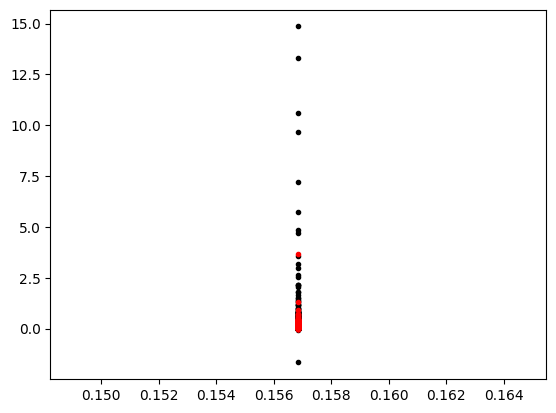

In [79]:
plt.plot(pred_t[:,0],Y_train[:,0],'k.')
plt.plot(pred[:,0],Y_dev[:,0],'r.')

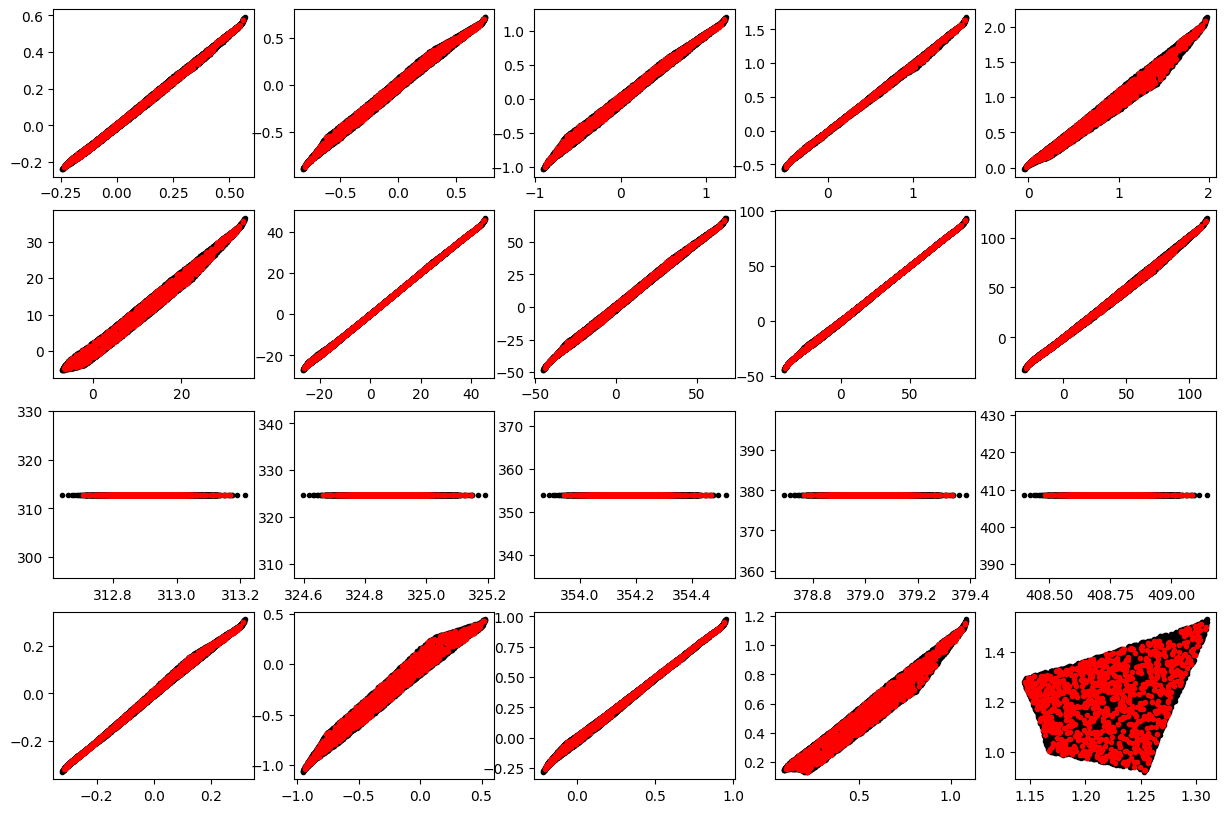

In [ ]:
fig, ax = plt.subplots( len(flds), len(dates),figsize=(15, 10))

ax=ax.flatten()
for i in np.arange(nflds):
  ax[i].plot(pred_t[:,i],Y_train[:,i],'k.')
  ax[i].plot(pred[:,i],Y_dev[:,i],'r.')

